In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# exec('some_var = 2')

In [36]:
# #creating the synthetic data
# row_count = 500
# X_vars = [np.random.rand(row_count, 1)*np.random.randint(2,10) for i in range(1)]
# Y_vars = [ x_var*(index+2) for index,x_var in enumerate(X_vars)]

# X_cols = [f'X{i}' for i in range(len(Y_vars))]
# Y_cols = [f'Y{i}' for i in range(len(Y_vars))]
# all_data = pd.DataFrame(np.concatenate(Y_vars+X_vars, axis=1), columns=Y_cols+X_cols)
# all_data.head(2)


# seq values 
row_count = 500
val_count = 100
test_count =100
val_st,val_end = row_count-(val_count+test_count),row_count-test_count

data=pd.DataFrame({'seq_values':np.sin(list(range(row_count))) })
data['index'] = data.index
data.head()

,seq_values,index
0,0.000000,0
1,0.841471,1
2,0.909297,2
3,0.141120,3
4,-0.756802,4


In [37]:
train_data = data.iloc[:val_st].reset_index(drop=True)
train_data['tgt_values'] = train_data['seq_values'].shift(-1)
#shiting to start the indexing from 1 onwards to align with the hidden states since h0 is random initiation
train_data = train_data.dropna().shift(1)

val_data = data.iloc[val_st:val_end].reset_index(drop=True)
val_data['tgt_values'] = val_data['seq_values'].shift(-1)
#shiting to start the indexing from 1 onwards to align with the hidden states since h0 is random initiation
val_data = val_data.dropna().shift(1)

test_data = data.iloc[val_end:row_count].reset_index(drop=True)
test_data['tgt_values'] = test_data['seq_values'].shift(-1)
#shiting to start the indexing from 1 onwards to align with the hidden states since h0 is random initiation
test_data = test_data.dropna().shift(1)

# plt.figure(figsize=(25,3))
# sns.lineplot(data=train_data, y='seq_values', x='index',label='train')
# sns.lineplot(data=val_data, y='seq_values', x='index', label='validation')
# sns.lineplot(data=test_data, y='seq_values', x='index', label='testing')

In [160]:
wxh,whh,why,cy,ch = [np.random.normal() for i in range(5)]
learning_rate = 0.01

xt_trn = train_data['seq_values'].to_numpy()
yt_true_trn = train_data['tgt_values'].to_numpy()

xt_val = val_data['seq_values'].to_numpy()
yt_true_val = val_data['tgt_values'].to_numpy()

trn_loss_arry, val_loss_arry,  = [],[]

grad_dct = {'wxh':[],'whh':[],'why':[],'cy':[],'ch':[]}

for epoch in range(0,15):

    ht_arry,yt_trn_pred_arry= [0],[None]
    trn_epoch_loss, val_epoch_loss =0,0
    delta_y_arry = [None]

    # forward pass
    for t_step in range(1,len(train_data)):
        ht = np.tanh(ch + whh*ht_arry[t_step-1] + wxh*xt_trn[t_step])
        yt_pred = cy + why*ht

        ht_arry.append(ht)
        yt_trn_pred_arry.append(yt_pred)

        delta_y = yt_true_trn[t_step]-yt_pred
        delta_y_arry.append(delta_y)

        loss = delta_y**2
        trn_epoch_loss+=loss

    ht_val_arry, yt_val_pred_arry= [0],[None]

    for t_step in range(1,len(val_data)):
        ht = np.tanh(ch + whh*ht_val_arry[t_step-1] + wxh*xt_val[t_step])
        yt_pred = cy + why*ht

        ht_val_arry.append(ht)
        yt_val_pred_arry.append(yt_pred)
        
        val_loss = (yt_true_val[t_step]-yt_pred)**2
        val_epoch_loss+=val_loss

    trn_loss_arry.append(trn_epoch_loss)
    val_loss_arry.append(val_epoch_loss)

    # if epoch%50==0:
    print(f'train_cost:{trn_epoch_loss} | validation_cost: {val_epoch_loss}' )

    dwhy,dwxh, dwhh, dch, dcy =0,0,0,0,0

    #backprob through time
    for t_step in reversed(range(1,len(train_data))):
        dy = (-2)*delta_y_arry[t_step] # derivative of squared loss
        dh = dy*why

        dwhh+= dh*(1-ht_arry[t_step]**2)*ht_arry[t_step-1]
        dwxh+= dh*(1-ht_arry[t_step]**2)*xt_trn[t_step]
        dwhy+=dy*dh
        dcy+=dy
        dch+=dh*(1-ht_arry[t_step]**2)

    for param, grad, key in zip([wxh,whh,why,cy,ch],[dwxh,dwhh,dwhy,dcy,dch],['wxh','whh','why','cy','ch']):
        grad = np.clip(grad, -8, 8)
        grad_dct[key].append(param-learning_rate*grad)

    wxh,whh,why,cy,ch = grad_dct['wxh'][-1],grad_dct['whh'][-1],grad_dct['why'][-1],grad_dct['cy'][-1],grad_dct['ch'][-1]


train_cost:584.256784298349 | validation_cost: 190.42990450831653
train_cost:463.80467085997606 | validation_cost: 150.9316858540723
train_cost:349.9896741004332 | validation_cost: 113.50541469764208
train_cost:239.85594112031492 | validation_cost: 77.49289431269732
train_cost:167.29306129162572 | validation_cost: 53.86166632153526
train_cost:114.8363790771572 | validation_cost: 37.02414330640118
train_cost:75.5468384896801 | validation_cost: 25.14972036665624
train_cost:121.54187206107599 | validation_cost: 38.47974024819148
train_cost:76.13587429586056 | validation_cost: 23.969336586061836
train_cost:86.83709151750546 | validation_cost: 28.14215543268113
train_cost:80.21601167441328 | validation_cost: 25.146495155040558
train_cost:83.66516123712314 | validation_cost: 26.154924863629667
train_cost:87.50798123146448 | validation_cost: 27.80387418503619
train_cost:93.33647038497821 | validation_cost: 30.10187309667465
train_cost:98.95570884694492 | validation_cost: 31.69361066300033


In [41]:
# yt_true_trn
# yt_trn_pred_arry

<Axes: >

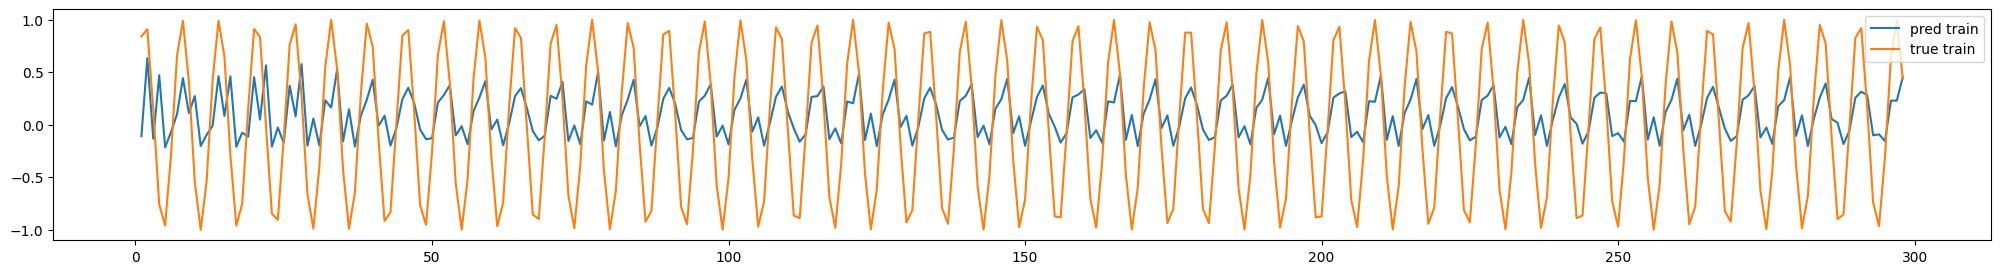

In [161]:
plt.figure(figsize=(25,3))
sns.lineplot(x=range(len(yt_trn_pred_arry)), y=yt_trn_pred_arry, label='pred train')
sns.lineplot(x=range(len(yt_true_trn)), y=yt_true_trn, label='true train')

<Axes: >

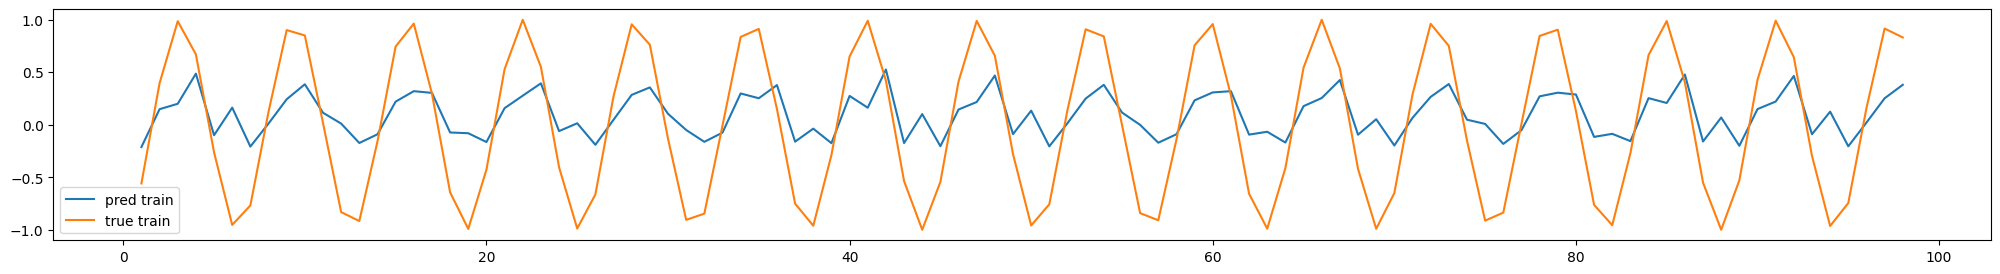

In [163]:
plt.figure(figsize=(25,3))
sns.lineplot(x=range(len(yt_val_pred_arry)), y=yt_val_pred_arry, label='pred train')
sns.lineplot(x=range(len(yt_true_val)), y=yt_true_val, label='true train')